# Part 1: causality


## Preparation

*This is Exercise 2.8.3 in Imai (2016).*

One longstanding debate in the study of international relations
concerns the question of whether individual political leaders can make a difference.  Some emphasize that leaders with different ideologies and personalities can significantly affect the course of a nation. Others argue that political leaders are severely constrained by historical and institutional forces.  Did individuals like Hitler, Mao, Roosevelt, and Churchill make a big difference?  The difficulty of empirically testing these arguments stems from the fact that the change of leadership is not random and there are many confounding factors to be adjusted for.

In this exercise, we consider a *natural experiment* in which the
success or failure of assassination attempts is assumed to be
essentially random.

This exercise is based on:
Jones, Benjamin F, and Benjamin A Olken. 2009. “[Hit or Miss?
 The Effect of Assassinations on Institutions and
 War.](http://dx.doi.org/10.1257/mac.1.2.55)”
 *American Economic Journal: Macroeconomics* 1(2): 55–87.

You load the data as follows


```python
gh_raw = "https://raw.githubusercontent.com/"
user = "kosukeimai/"
repo = 'qss/'
branch = "master/"
filepath = "CAUSALITY/leaders.csv"

url = gh_raw + user + repo + branch + filepath
df = pd.read_csv(url)```

Each observation of the CSV data set
`leaders.csv` contains information about an assassination
attempt.  The variables are:

- `country`: The name of the country
- `year`: Year of assassination
- `leadername`: Name of leader who was targeted
- `age`: Age of the targeted leader
- `politybefore`: Average polity score during the 3 year period prior to the attempt
- `polityafter`: Average polity score during the 3 year period after the attempt
- `civilwarbefore`: 1 if country is in civil war during the 3 year period prior to the attempt, or 0
- `civilwarafter`: 1 if country is in civil war during the 3 year period after the attempt, or 0
- `interwarbefore`: 1 if country is in international war during the 3 year period prior to the attempt, or 0
- `interwarafter`: 1 if country is in international war during the 3 year period after
the attempt, or 0
- `result`: Result of the assassination attempt, one of 10 categories described
below

The `polity` variable represents the so-called *polity score*
from the Polity Project.  The Polity Project systematically documents
and quantifies the regime types of all countries in the world from
1800.  The polity score is a 21-point scale ranging from -10
(hereditary monarchy) to 10 (consolidated democracy).  

The `result` variable is a 10 category factor variable describing
the result of each assassination attempt.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

sns.set()

%matplotlib inline

In [2]:

# Read data
gh_raw = "https://raw.githubusercontent.com/"
user = "kosukeimai/"
repo = 'qss/'
branch = "master/"
file = "CAUSALITY/leaders.csv"

url = gh_raw + user + repo + branch + file
df = pd.read_csv(url)

## Question 1

- How many assassination attempts are recorded in the data?  

In [3]:
df.shape[0]

250

- How many countries experience at least one leader assassination attempt?
(recall that the `nunique` method for Series returns its number of unique values)

In [4]:
df['country'].nunique()

88

- What is the average number of assination attempts (per year) among these countries?

In [5]:
'%.2f' % (df.shape[0] / (df.year.max()-df.year.min())) # print it rounded to two digits

'2.03'

## Question 2
Create a new binary variable named `success` that is equal
to 1 if a leader dies from the attack and to 0 if the leader
survives.  Store this new variable as part of the original data
frame.  

In [6]:
df['success'] = df.result.str.contains('dies').astype(int)

What is the overall success rate of leader assassination?

In [7]:
df['success'].mean()

0.216

Does the result speak to the validity of the assumption that the
success of assassination attempts is randomly determined? Are the outcomes balanced?

## Question 3


Investigate whether the average polity score over 3 years prior
  to an assassination attempt differs on average between successful
  and failed attempts.  Also, examine whether there is any difference
  in the age of targeted leaders between successful and failed
  attempts.  Briefly interpret the results in light of the validity of
  the aforementioned assumption.

*Answer: it seems to be that politybefore and age (especially) are correlated with "success". See figures and tables below.*

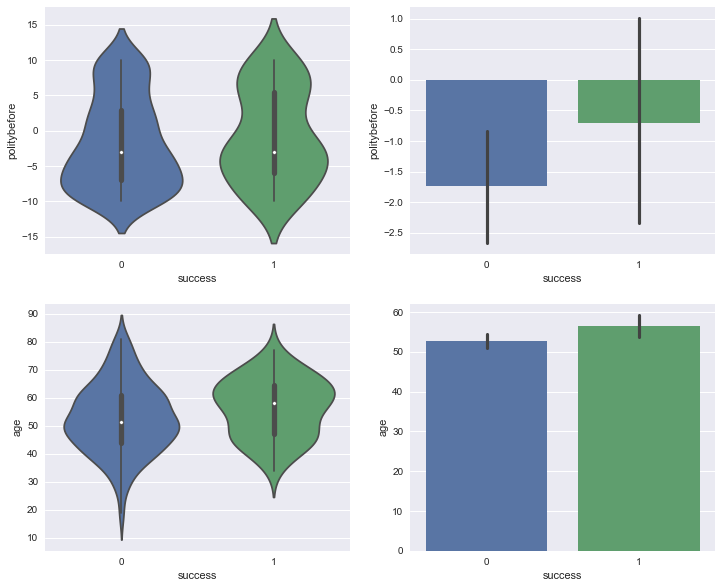

In [8]:
f,ax = plt.subplots(2,2,figsize=(12,10))
for index, var in enumerate(['politybefore', 'age']):
    sns.violinplot(x='success', y=var, data=df, ax=ax[index][0])
    sns.barplot(x='success', y=var, data=df, ax=ax[index][1])


In [9]:
gb_success = df.groupby('success')

gb_success.politybefore.describe()

,count,mean,std,min,25%,50%,75%,max
success,,,,,,,,
0,196.0,-1.743197,6.417421,-10.0,-7.0,-3.0,3.0,10.0
1,54.0,-0.703704,6.541808,-10.0,-6.0,-3.0,5.5,10.0


In [10]:
gb_success.age.describe()

,count,mean,std,min,25%,50%,75%,max
success,,,,,,,,
0,196.0,52.714286,12.348778,18.0,44.00,51.5,61.00,81.0
1,54.0,56.462963,10.428034,34.0,47.25,58.0,64.75,77.0



## Question 4

Repeat the same analysis as in the previous question, but this
  time using the country's experience of civil and international war.
  Create a new binary variable in the data frame called
  `warbefore`.  Code the variable such that it is equal to 1 if
  a country is in either civil or international war during the 3 years
  prior to an assassination attempt.  Provide a brief interpretation
  of the result.

*Answer: We see that war after seems to be affected by success of the attack - warbefore does not seem to alter the probability of success.*

In [11]:
df['warbefore'] = df[['interwarbefore','civilwarbefore']].max(1)
df['warafter'] = df[['interwarafter','civilwarafter']].max(1)

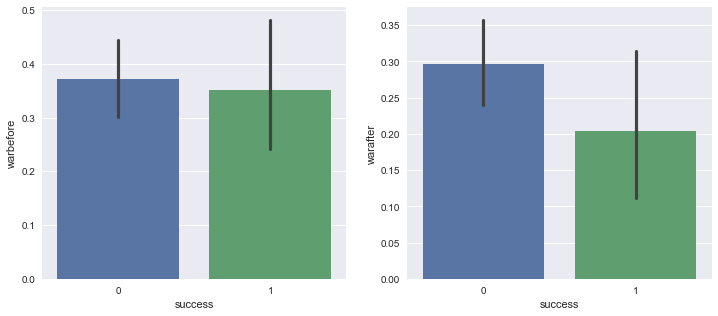

In [12]:
f,ax = plt.subplots(1,2,figsize=(12,5))
for index, var in enumerate(['warbefore', 'warafter']):    
    sns.barplot(x='success', y=var, data=df, ax=ax[index])



## Question 5

- Does successful leader assassination cause democratization?
- Does successful leader assassination lead countries to war?

In [13]:
for var_type in ['war', 'polity']:
    def diff_mean(group):
        return (group[var_type+'after']-group[var_type+'before']).mean()
    print(var_type, '%.3f' % df.groupby('success').apply(diff_mean).diff().iloc[1])

war -0.072
polity 0.093


### Plots of democratization

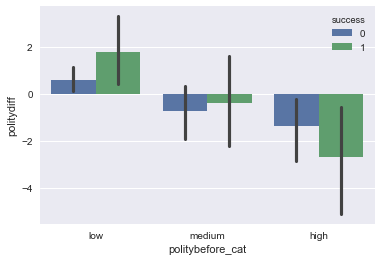

In [14]:
df['politydiff'] = df.polityafter - df.politybefore
df['politybefore_cat'] = pd.cut(df.politybefore, [-11,-3,3,11], labels=['low', 'medium', 'high'])

sns.barplot(x='politybefore_cat',hue='success',y='politydiff',data=df)

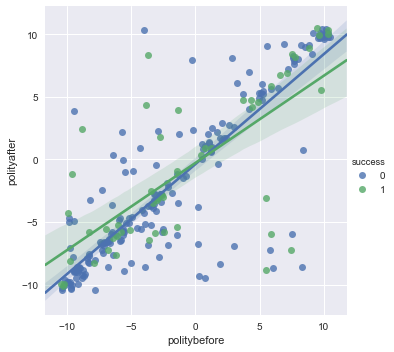

In [15]:
sns.lmplot(x='politybefore', y='polityafter', hue='success', data=df, x_jitter=.5, y_jitter=.5)

### Plots of war reduction

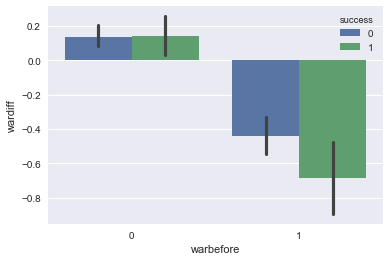

In [16]:
df['wardiff'] = df.warafter - df.warbefore
sns.barplot(x='warbefore', y='wardiff', hue='success', data=df)

# Part 2: regression in supervised machine learning

In this second part of the exercise we will implement a machine learning model for predicting tips. We will use the same data as in Exercise 1.

Load the tips data from Seaborn.

In [17]:
tips = sns.load_dataset('tips')

## Question 1

Specify y and X for the supervised machine learning problem. As part of this convert categorical/discrete data to dummy variables. Note that Pandas *get_dummies* with the keyword argument `drop_first=True` may be useful.


In [18]:
X = pd.get_dummies(tips.drop('tip',1), drop_first=True).values
y = tips.tip.values

## Question 2

Using 5-fold cross-validation compare the MAE and RMSE of OLS and ridge regression. For ridge regression use `alpha=100` and `random_state=123`.

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.linear_model import Ridge, LinearRegression

kf = KFold(n_splits=5, random_state=123)

measures = {'Ridge':[], 'OLS':[]}

models = [('Ridge', Ridge(alpha=100)), ('OLS', LinearRegression())]

# cross validation loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
    for model_name,model in models:
    
        y_pred = model.fit(X_train, y_train).predict(X_test)         

        measures[model_name].append({'mae': mae(y_test, y_pred), 
                                     'rmse': np.sqrt(mse(y_test, y_pred))    })

In [20]:
def mean_est(m):
    return pd.DataFrame(measures[m]).mean().rename(m)

pd.concat([mean_est(m) for m in ['Ridge','OLS']], axis=1).round(2)

,Ridge,OLS
mae,0.76,0.79
rmse,1.01,1.04


## Question 3

Explain in words why the ridge regression performs better than the OLS regression.

*Answer: The ridge regression solves the part of 'overfitting' where we have excessively large estimates.*